# Lesson 2 : State Farm

## Setup the directories for the data

In [1]:
%pwd

u'/home/ubuntu/nbs'

In [4]:
import os

In [2]:
#Path of current directory and the data directory
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir + '/data/statefarm/'

In [20]:
#setup the folder for the validation data
%mkdir -p $DATA_HOME_DIR'valid'

In [2]:
#create the classes for the validation data
for root, dirs, files in os.walk(DATA_HOME_DIR+'train/'):
    for name in dirs:
        os.mkdir(os.path.join(DATA_HOME_DIR+'valid', name))

NameError: name 'DATA_HOME_DIR' is not defined

In [7]:
import numpy as np
from glob import glob

In [38]:
#move 20% of the training data to the respective validation folders
for root, dirs, files in os.walk(DATA_HOME_DIR+'train/'):
    for name in dirs:
        g = glob(DATA_HOME_DIR + 'train/' + name + '/*.jpg')
        shuffle = np.random.permutation(g)
        for i in range(int(0.2*shuffle.size)): 
            os.rename(shuffle[i], DATA_HOME_DIR + 'valid/' + name + '/' + os.path.basename(shuffle[i]))

In [40]:
#setup the test data
%mkdir -p $DATA_HOME_DIR'test/none/'

In [44]:
#move all the files in the folder created above
%cd $DATA_HOME_DIR'test/'
%mv *.jpg  none/

/home/ubuntu/nbs/data/statefarm/test


In [4]:
%cd $LESSON_HOME_DIR

/home/ubuntu/nbs


## Start creating the linear model

In [8]:
%matplotlib inline
from __future__ import division,print_function
import json
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots, get_batches, plot_confusion_matrix, get_data

In [9]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [10]:
#path for the data and the arrays to save
path='data/statefarm/'
model_path=path+'model/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [18]:
#write the function to save the arrays
import bcolz
def save_array(path, arr): 
    x = bcolz.carray(arr, rootdir=path, mode='w')
    x.flush()
    
def load_array(path):
    return bcolz.open(path)[:]

In [12]:
batch_size=64

In [13]:
train_batches = get_batches(path+'train/', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [15]:
#method to one hot encode the classes
def onehot(x):
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1, 1)).todense())

In [16]:
#get the classes from the batches and onehotencode them to labels
train_classes = train_batches.classes
val_classes = val_batches.classes
train_labels = onehot(train_classes)
val_labels = onehot(val_classes)

In [64]:
#save the arrays of labels
save_array(model_path+'train_labels.bc', train_labels)
save_array(model_path+'val_labels.bc', val_labels)

In [65]:
#use the get_data method to get the concatenated data
train_data = get_data(path+'train/')
val_data = get_data(path+'valid/')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [66]:
#save the data for quick load 
save_array(model_path+'train_data.bc', train_data)
save_array(model_path+'val_data.bc', val_data)

In [19]:
#loading the labels
train_labels = load_array(model_path+'train_labels.bc')
val_labels = load_array(model_path+'val_labels.bc')

In [20]:
#load the data
train_data = load_array(model_path+'train_data.bc')
val_data = load_array(model_path+'val_data.bc')

In [22]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

In [16]:
#getting the features
# train_features = model.predict(train_data, batch_size=batch_size)
val_features = model.predict(val_data, batch_size=batch_size)

In [17]:
#saving the features
save_array(model_path+'train_features.bc', train_features)
save_array(model_path+'val_features.bc', val_features)

In [23]:
#load the features
train_features = load_array(model_path+'train_features.bc')
val_features = load_array(model_path+'val_features.bc')

In [24]:
#creating our linear model
lm = Sequential([Dense(10,activation='softmax', input_shape=(1000,))])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
#fitting the linear model to the features
lm.fit(train_features, train_labels, nb_epoch=20, batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 17943 samples, validate on 4481 samples
Epoch 1/20
17943/17943 [==============================] - 0s - loss: 1.3652 - acc: 0.5665 - val_loss: 1.4526 - val_acc: 0.5392
Epoch 2/20
17943/17943 [==============================] - 0s - loss: 1.3558 - acc: 0.5745 - val_loss: 1.4359 - val_acc: 0.5336
Epoch 3/20
17943/17943 [==============================] - 0s - loss: 1.3477 - acc: 0.5736 - val_loss: 1.4083 - val_acc: 0.5675
Epoch 4/20
17943/17943 [==============================] - 0s - loss: 1.3398 - acc: 0.5796 - val_loss: 1.4180 - val_acc: 0.5349
Epoch 5/20
17943/17943 [==============================] - 0s - loss: 1.3324 - acc: 0.5832 - val_loss: 1.4143 - val_acc: 0.5314
Epoch 6/20
17943/17943 [==============================] - 0s - loss: 1.3248 - acc: 0.5851 - val_loss: 1.3887 - val_acc: 0.5780
Epoch 7/20
17943/17943 [==============================] - 0s - loss: 1.3172 - acc: 0.5852 - val_loss: 1.3987 - val_acc: 0.5722
Epoch 8/20
17943/17943 [==============================] - 0s -

In [22]:
lm.summary()

INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.12-64/lock_dir/lock


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_6 (Dense)                  (None, 10)            10010       dense_input_3[0][0]              
Total params: 10010
____________________________________________________________________________________________________


## Visualisation of our model's prediction chops

### Things we will be visualising
 - Random correct predictions
 - Random incorrect predictions
 - Most correct predictions
 - Most correct predictions

In [23]:
#we get the predicted classes
preds = lm.predict_classes(val_features, batch_size=batch_size)

3136/4481 [===================>..........] - ETA: 0s

In [87]:
#next we get the probabilities of the predictions
probs = lm.predict_proba(val_features, batch_size=batch_size)

3072/4481 [===================>..........] - ETA: 0s

In [88]:
probs

array([[  6.3305e-01,   1.4421e-01,   3.9907e-02, ...,   4.4920e-02,   2.6270e-02,   6.9425e-02],
       [  9.9736e-01,   5.4942e-12,   3.7479e-06, ...,   9.9397e-05,   2.2835e-03,   1.9055e-04],
       [  9.7547e-01,   4.8843e-06,   1.7094e-10, ...,   1.0487e-04,   4.0425e-07,   1.8136e-06],
       ..., 
       [  1.4105e-03,   3.0844e-03,   3.8038e-04, ...,   1.2099e-04,   8.8623e-04,   9.9335e-01],
       [  2.7177e-03,   1.7476e-01,   8.1880e-03, ...,   1.6183e-02,   3.3886e-02,   3.4005e-01],
       [  8.0781e-02,   9.9182e-02,   1.0933e-01, ...,   1.1411e-01,   1.0830e-01,   1.3748e-01]], dtype=float32)

In [44]:
val_classes = val_batches.classes

In [42]:
filenames = val_batches.filenames

In [43]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path+'valid/'+filenames[i]) for i in idx], titles=titles)

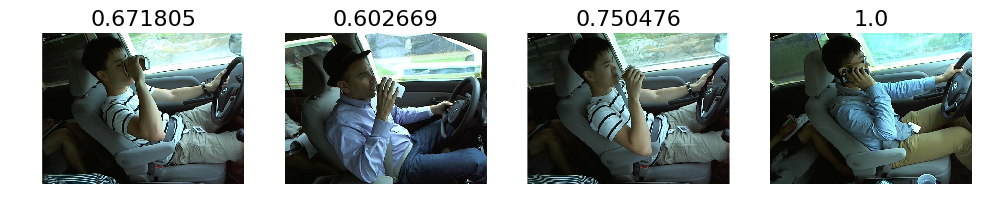

In [89]:
#plotting correct random images
correct = np.where(preds==val_classes)[0]
idx = permutation(correct)[:4]
plots_idx(idx, probs[idx, val_classes[idx]])

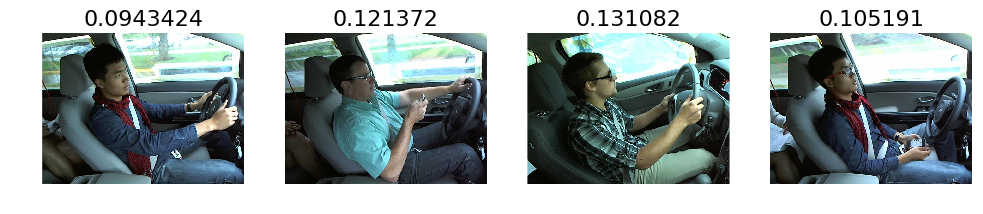

In [93]:
#plotting random incorrect predictions, 
incorrect = np.where(preds!=val_classes)[0]
idx = permutation(incorrect)[:4]
plots_idx(idx, probs[idx, val_classes[idx]])

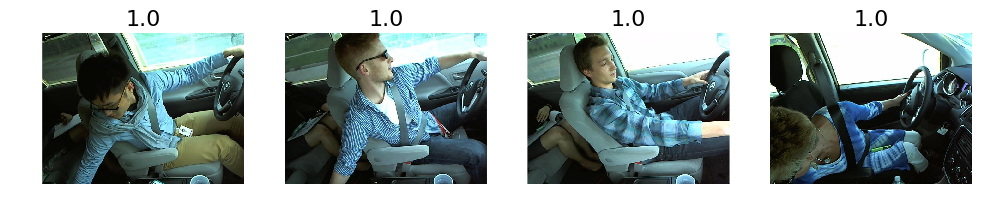

In [116]:
#most correctly predicted images
correct = np.where(preds==val_classes)[0]
probs_correct = probs[correct, val_classes[correct]]
idx = np.argsort(probs_correct)[::-1][:4]
plots_idx(correct[idx], probs_correct[idx])

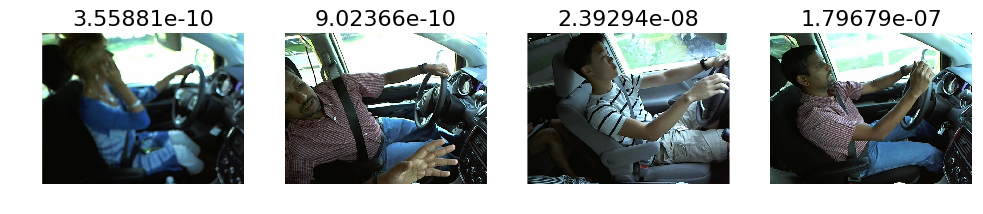

In [137]:
#most incorrectly predicted images
incorrect = np.where(preds!=val_classes)[0]
probs_incorrect = probs[incorrect, val_classes[incorrect]]
idx = np.argsort(probs_incorrect)[:4]
plots_idx(incorrect[idx], probs_incorrect[idx])

In [138]:
#creating the confustion matrix
cm = confusion_matrix(val_classes, preds)

[[339   9   6  76   4   6  14   6  13  24]
 [ 29 264   5  79   1   5  19  20  16  15]
 [ 37   3 284  48   3   5  27  17  35   4]
 [ 18  16   3 399   7   1  10   3   5   7]
 [ 31  11   7 158 200   7  13  10  14  14]
 [ 30  14   2  63   1 280  17  17  23  15]
 [ 26  24  11  54   4  11 249  15  45  26]
 [  9  11   3  58   4   9   8 271  15  12]
 [ 11  11  17  65   2   6  19  26 187  38]
 [ 64  15   8  50  10   6  12  18  15 227]]


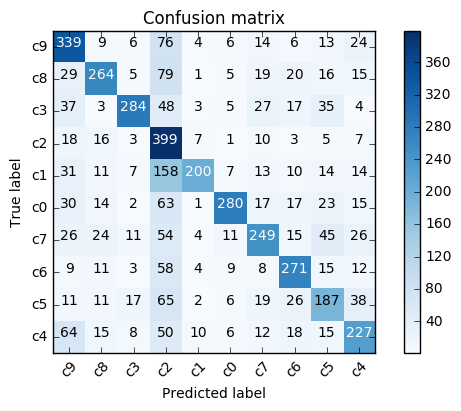

In [139]:
plot_confusion_matrix(cm, val_batches.class_indices)

## Finetuning the vgg model

In [16]:
##seeing the configuration of the existing default vgg model
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [17]:
## Removing the last layer and setting the trainable property of all the layers to false
## So that they do not get trained again
model.pop()
for layer in model.layers: layer.trainable=False

In [18]:
## adding the new layer to the model
model.add(Dense(10, activation="softmax"))

In [21]:
??model.fit_generator

In [19]:
##next we create batches from the data that has already been processed (one hot encoded)
gen = image.ImageDataGenerator()
batches = gen.flow(train_data, train_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=True)

In [25]:
# next we write a function for fitting the model
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=nb_epoch,
                       validation_data=val_batches, nb_val_samples=val_batches.N)

In [20]:
# we will compile the model now
opt = RMSprop(lr=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
17943/17943 [==============================] - 575s - loss: 14.6528 - acc: 0.0888 - val_loss: 14.6793 - val_acc: 0.0893
Epoch 2/2
17943/17943 [==============================] - 578s - loss: 14.6790 - acc: 0.0893 - val_loss: 14.7189 - val_acc: 0.0868


4481

In [35]:
model.save_weights(model_path+'finetune1.h5')

In [36]:
model.evaluate(val_data, val_labels)

4481/4481 [==============================] - 117s   


[14.679300906269233, 0.089265788886409278]

In [22]:
#loading the weights of the model saved after training last time
model.load_weights(model_path+'finetune1.h5')

In [23]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [28]:
fit_model(model, batches, val_batches, nb_epoch=1)

Epoch 1/1
17943/17943 [==============================] - 577s - loss: 14.6682 - acc: 0.0900 - val_loss: 14.6793 - val_acc: 0.0893


In [27]:
#Trying to improve the accuracy by making all layers trainable
for layer in model.layers: layer.trainable=True

In [30]:
test_batches, preds = vgg.test(path+'test/', batch_size=batch_size*2)

Found 79726 images belonging to 1 classes.


In [31]:
#getting the filenames
filenames = test_batches.filenames

In [10]:
#saving the results array
results_path = path+'results/'
if not os.path.exists(results_path): os.mkdir(results_path)

In [46]:
save_array(results_path+'test_preds.dat', preds)
save_array(results_path+'filenames.dat', filenames)

In [47]:
#savingt the trained model weights again
model.save_weights(model_path+'finetune2.h5')

In [11]:
#load the results and the filenames
preds = load_array(results_path+'test_preds.dat')
filenames = load_array(results_path+'filenames.dat')

In [27]:
#extracting the image names from the filenames
ids = np.array([f.replace('none/','') for f in filenames])

In [20]:
#clipping the predictions to reduce log loss
clipped_preds = preds.clip(min=0.05, max=0.95)

In [60]:
#Joining the columns to create data for the submission file
subm = np.hstack((ids.reshape(ids.shape[0],1), clipped_preds))

In [75]:
%cd $DATA_HOME_DIR

/home/ubuntu/nbs/data/statefarm


In [76]:
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt="%s"
           ,header='img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9',delimiter=',', comments='')

In [77]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink('data/statefarm/'+submission_file_name)

/home/ubuntu/nbs


/home/ubuntu/nbs/data/statefarm/submission1.csv